## Import Stuff

In [8]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras_tuner as kt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

## Model Variables

In [9]:
rolling_window   = 50    # length of the input sequence
epochs           = 10
batch_size       = 32

# Manual hyperparameters (for “manual tuning”)
rnn_units        = 64
learning_rate    = 1e-3

## Data Pre-processing

In [10]:
# Load and prepare data
combined_stocks_df = pd.read_csv("../filtered_stocks_combined.csv")

# Convert Date to datetime and set as index
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])
combined_stocks_df.set_index("Date", inplace=True)

# Drop unnecessary columns if any
combined_stocks_df = combined_stocks_df.drop(columns=["index"])  # Optional

# Pivot to multi-level columns: Ticker as level 1, feature as level 2
stocks_df = combined_stocks_df.pivot_table(
    index=combined_stocks_df.index,
    columns="ticker",
    values=[col for col in combined_stocks_df.columns if col != "ticker"]
)

# Sort columns for clarity
stocks_df = stocks_df.sort_index(axis=1, level=0)

# Swap the column MultiIndex levels
stocks_df_leveled = stocks_df.swaplevel(axis=1)

# Sort by ticker (Level 0)
stocks_df_leveled = stocks_df_leveled.sort_index(axis=1, level=0)

## Dataset Split

In [11]:
#Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

# Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

# Compute Logarithmic Returns, split into train, val and test sets
for ticker in stocks_df_leveled.columns.levels[0]:
    stocks_df_leveled.loc[:, (ticker, 'log_return')] = np.log(
        stocks_df_leveled[ticker]['Close'] / stocks_df_leveled[ticker]['Close'].shift(1)
    )

    df = stocks_df_leveled[ticker].dropna().sort_index()
    total_len = len(df)
    train_end = int(total_len * 0.6)
    val_end = train_end + int(total_len * 0.2)

    train_dict[ticker] = df.iloc[:train_end]
    val_dict[ticker] = df.iloc[train_end:val_end]
    test_dict[ticker] = df.iloc[val_end:]

train_df = pd.concat(train_dict, names=["Ticker", "Date"])
val_df = pd.concat(val_dict, names=["Ticker", "Date"])
test_df = pd.concat(test_dict, names=["Ticker", "Date"])

## Feature Scaling & Extraction

In [12]:
# Define features and binary classification target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_df['target'] = (train_df['log_return'] > 0).astype(int)
val_df['target'] = (val_df['log_return'] > 0).astype(int)
test_df['target'] = (test_df['log_return'] > 0).astype(int)

# Extract features and target
X_train = train_df[features]
y_train = train_df['target']
X_val = val_df[features]
y_val = val_df['target']
X_test = test_df[features]
y_test = test_df['target']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled)

[[ 0.70832579  0.73573349  0.71524614  0.74380959  0.79802262]
 [ 0.74724251  0.75608693  0.7577544   0.74365754  0.61620678]
 [ 0.75180306  0.7548808   0.76358586  0.76874545  0.59778391]
 ...
 [ 0.4136229   0.40884224  0.41920757  0.4079205  -0.36326138]
 [ 0.40515548  0.40143962  0.41581612  0.40863512 -0.36052951]
 [ 0.40410655  0.40288698  0.41553989  0.40731231 -0.29423036]]


## Create RNN Sequences

In [13]:
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

# convert to numpy arrays
y_train_arr = y_train.values
y_val_arr   = y_val.values
y_test_arr  = y_test.values

# build sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_arr, rolling_window)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_arr,   rolling_window)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_arr,  rolling_window)
X_train_seq

array([[[-0.26703953, -0.27245509, -0.27022423, -0.26965071,
          1.71810283],
        [-0.27188892, -0.26886686, -0.26756939, -0.26438986,
          1.31218769],
        [-0.26212934, -0.26713305, -0.26087855, -0.26489161,
          1.65206891],
        ...,
        [-0.22734753, -0.22613972, -0.22469282, -0.22628664,
          2.64857337],
        [-0.24885813, -0.24278431, -0.24676029, -0.24214524,
          4.72968661],
        [-0.24884293, -0.25213181, -0.27390726, -0.27215951,
          7.8978525 ]],

       [[-0.27188892, -0.26886686, -0.26756939, -0.26438986,
          1.31218769],
        [-0.26212934, -0.26713305, -0.26087855, -0.26489161,
          1.65206891],
        [-0.26387755, -0.26500724, -0.26285818, -0.26023895,
          1.7278263 ],
        ...,
        [-0.24885813, -0.24278431, -0.24676029, -0.24214524,
          4.72968661],
        [-0.24884293, -0.25213181, -0.27390726, -0.27215951,
          7.8978525 ],
        [-0.25838969, -0.25869014, -0.26526749, 

## Autotuner Model (Base)

In [14]:
def build_model_hp(hp):
    units = hp.Int('units', 16, 128, step=16)
    lr    = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model = Sequential([
        SimpleRNN(units, input_shape=(rolling_window, len(features))),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model_hp,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='rnn_tuner',
    project_name='stock_class_rnn'
)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)

best_hp   = tuner.get_best_hyperparameters(num_trials=1)[0]
auto_model = tuner.hypermodel.build(best_hp)
history_auto = auto_model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)


Reloading Tuner from rnn_tuner\stock_class_rnn\tuner0.json
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5021 - loss: 0.7095 - val_accuracy: 0.4949 - val_loss: 0.6948
Epoch 2/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4975 - loss: 0.7058 - val_accuracy: 0.5075 - val_loss: 0.6946
Epoch 3/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5025 - loss: 0.7039 - val_accuracy: 0.4975 - val_loss: 0.7003
Epoch 4/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4981 - loss: 0.7062 - val_accuracy: 0.5040 - val_loss: 0.6982
Epoch 5/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4991 - loss: 0.7069 - val_accuracy: 0.5073 - val_loss: 0.7136
Epoch 6/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5059 - loss: 0.7049 - val_accuracy: 0.5111 - val_loss: 0.7051
Epoch 7/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5060 - loss: 0.7039 - val_accuracy: 0.5095 - val_loss: 0.7087
Epoch 8/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5035 - loss: 0.7066 - val

### Result Analysis & Evaluation

472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Auto‑Tuned Model:
  True Positives (correct UP)  : 3825
  True Negatives (correct DOWN): 3707


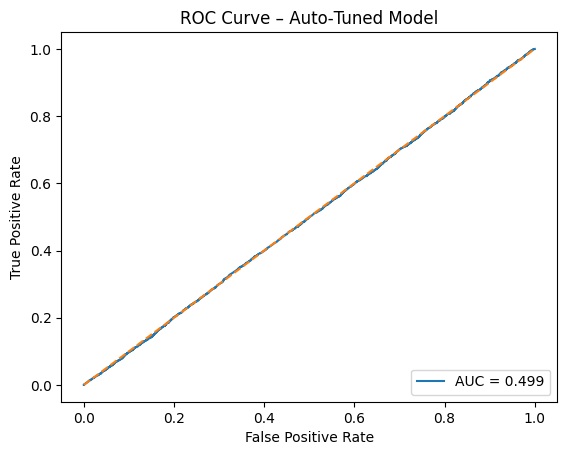

In [16]:
# 1) Compute actual counts
actual_up = (y_test_seq == 1).sum()
actual_down = (y_test_seq == 0).sum()

# 3) Auto model predictions & counts
y_prob_auto = auto_model.predict(X_test_seq).ravel()
y_pred_auto = (y_prob_auto > 0.5).astype(int)
pred_up_auto   = y_pred_auto.sum()
pred_down_auto = len(y_pred_auto) - pred_up_auto

# Auto‑tuned model counts
y_prob_auto  = auto_model.predict(X_test_seq).ravel()
y_pred_auto  = (y_prob_auto > 0.5).astype(int)

tp_auto = ((y_pred_auto == 1) & (y_test_seq == 1)).sum()
tn_auto = ((y_pred_auto == 0) & (y_test_seq == 0)).sum()

print("Auto‑Tuned Model:")
print(f"  True Positives (correct UP)  : {tp_auto}")
print(f"  True Negatives (correct DOWN): {tn_auto}")

# 6) Plot ROC for Auto‑tuned model
fpr_a, tpr_a, _ = roc_curve(y_test_seq, y_prob_auto)
auc_a = roc_auc_score(y_test_seq, y_prob_auto)

plt.figure()
plt.plot(fpr_a, tpr_a, label=f'AUC = {auc_a:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Auto‑Tuned Model')
plt.legend(loc='lower right')
plt.show()

## Auto Tuner (With 1 dense layer)

In [17]:
def build_model_hp(hp):
    # Hyperparameters to search:
    num_rnn     = hp.Int('num_rnn_layers',   1, 3)             # 1 to 3 stacked RNNs
    rnn_units   = hp.Int('rnn_units',        16, 128, step=16)
    lr          = hp.Float('lr',             1e-4, 1e-2, sampling='log')
    dense_units = hp.Int('dense_units',      0, 64,  step=16)  # 0 = no dense layer

    model = Sequential()
    # Stack RNN layers
    for i in range(num_rnn):
        return_seq = (i < num_rnn - 1)
        if i == 0:
            model.add(SimpleRNN(
                rnn_units,
                return_sequences=return_seq,
                input_shape=(rolling_window, len(features))
            ))
        else:
            model.add(SimpleRNN(rnn_units, return_sequences=return_seq))

    # Optional hidden Dense layer
    if dense_units > 0:
        model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model_hp,
    objective='val_accuracy',
    max_trials=5,                # increase trials to cover more combos
    executions_per_trial=1,
    directory='rnn_tuner',
    project_name='stock_class_rnn_hidden'
)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)

best_hp   = tuner.get_best_hyperparameters(num_trials=1)[0]
auto_model = tuner.hypermodel.build(best_hp)

history_auto = auto_model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)


Reloading Tuner from rnn_tuner\stock_class_rnn_hidden\tuner0.json
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5106 - loss: 0.6955 - val_accuracy: 0.5032 - val_loss: 0.6949
Epoch 2/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5126 - loss: 0.6938 - val_accuracy: 0.5073 - val_loss: 0.6934
Epoch 3/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5097 - loss: 0.6940 - val_accuracy: 0.5119 - val_loss: 0.6943
Epoch 4/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5125 - loss: 0.6932 - val_accuracy: 0.5084 - val_loss: 0.6943
Epoch 5/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5190 - loss: 0.6926 - val_accuracy: 0.5085 - val_loss: 0.6942
Epoch 6/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5203 - loss: 0.6928 - val_accuracy: 0.5079 - val_loss: 0.6932
Epoch 7/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5189 - loss: 0.6922 - val_accuracy: 0.5065 - val_loss: 0.6940
Epoch 8/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5210 - loss: 0.6923 - val

### Results & Analysis

472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Auto‑Tuned Model:
  True Positives (correct UP)  : 2915
  True Negatives (correct DOWN): 4572
  False Positives (incorrect UP): 2729
  False Negatives (incorrect DOWN): 4884
  Accuracy: 0.496


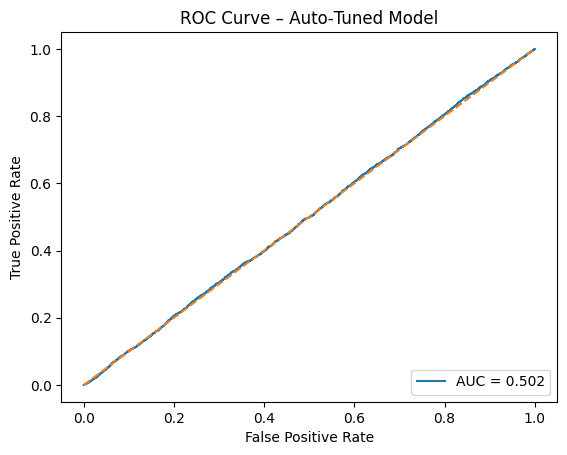

In [19]:
# 1) Compute actual counts
actual_up = (y_test_seq == 1).sum()
actual_down = (y_test_seq == 0).sum()

# 3) Auto model predictions & counts
y_prob_auto = auto_model.predict(X_test_seq).ravel()
y_pred_auto = (y_prob_auto > 0.5).astype(int)
pred_up_auto   = y_pred_auto.sum()
pred_down_auto = len(y_pred_auto) - pred_up_auto

# Auto‑tuned model counts
y_prob_auto  = auto_model.predict(X_test_seq).ravel()
y_pred_auto  = (y_prob_auto > 0.5).astype(int)

tp_auto = ((y_pred_auto == 1) & (y_test_seq == 1)).sum()
tn_auto = ((y_pred_auto == 0) & (y_test_seq == 0)).sum()

print("Auto‑Tuned Model:")
print(f"  True Positives (correct UP)  : {tp_auto}")
print(f"  True Negatives (correct DOWN): {tn_auto}")
print(f"  False Positives (incorrect UP): {pred_up_auto - tp_auto}")
print(f"  False Negatives (incorrect DOWN): {pred_down_auto - tn_auto}")

acc_auto = accuracy_score(y_test_seq, y_pred_auto)
print(f"  Accuracy: {acc_auto:.3f}")
# 6) Plot ROC for Auto‑tuned model
fpr_a, tpr_a, _ = roc_curve(y_test_seq, y_prob_auto)
auc_a = roc_auc_score(y_test_seq, y_prob_auto)

plt.figure()
plt.plot(fpr_a, tpr_a, label=f'AUC = {auc_a:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Auto‑Tuned Model')
plt.legend(loc='lower right')
plt.show()